Machine Learning models for obesity risk prediction

In [ ]:
# Import libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import math
import sklearn as sk
import xgboost as xgb
from hmmlearn.hmm import GaussianHMM
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Data loading

In [2]:
# Load data
data = pd.read_csv("Data_collection_and_cleaning/processed_data/csv_files/Processed_data.csv",
                   header= 0)

Descriptive analysis

In [3]:
data.head(2)

,subjid,sex,age_days,age_years,date_of_measurement,height_cm,weight_kg,bmi,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,763,2.089023,2015-11-13,87.0,13.2,17.439556,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1118,3.060980,2016-11-02,96.0,15.9,17.252604,1.30,Overweight


In [4]:
print(f"Number of rows: {data.shape[0]}, Number of columns: {data.shape[1]}")

Number of rows: 247663, Number of columns: 10


In [5]:
data.describe()

,age_days,age_years,height_cm,weight_kg,bmi,zbmi
count,247663.000000,247663.000000,247663.000000,247663.000000,247663.000000,247663.000000
mean,2302.077900,6.302875,117.018334,25.911639,17.422402,0.548033
std,1306.740792,3.577735,23.459458,15.057504,3.397402,1.316509
min,731.000000,2.001410,56.000000,4.750000,9.433962,-5.810000
25%,1129.000000,3.091097,97.000000,15.000000,15.231812,-0.340000
50%,2196.000000,6.012444,114.000000,20.400000,16.451348,0.450000
75%,3178.000000,8.701068,134.000000,32.500000,18.518263,1.360000
max,5478.000000,14.998255,202.000000,153.000000,48.836541,10.090000


In [6]:
# Check NA count
data.isna().sum()

subjid                 0
sex                    0
age_days               0
age_years              0
date_of_measurement    0
height_cm              0
weight_kg              0
bmi                    0
zbmi                   0
zbmi_type              0
dtype: int64

In [7]:
data.dtypes

subjid                  object
sex                     object
age_days                 int64
age_years              float64
date_of_measurement     object
height_cm              float64
weight_kg              float64
bmi                    float64
zbmi                   float64
zbmi_type               object
dtype: object

In [8]:
# Number of patients
len(data.subjid.unique())

62798

Plots

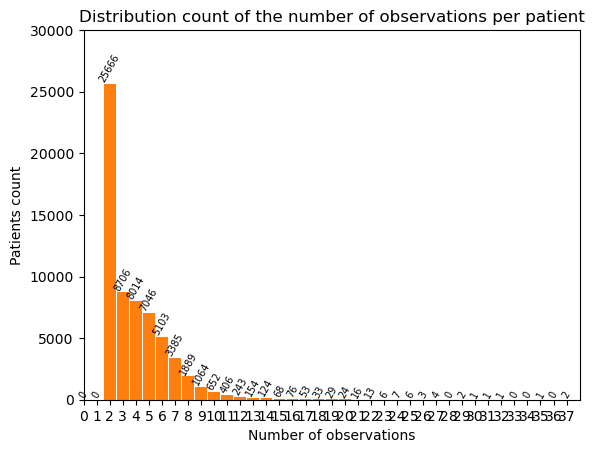

In [9]:
# Plot number of patients by number of obs
n_patients = data.value_counts("subjid")
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 30000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Distribution count of the number of observations per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Number of observations")

plt.show()

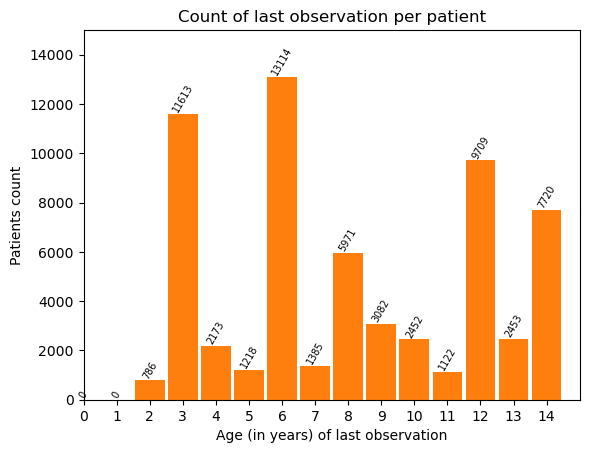

In [10]:
# Plot number of patients by age_years of obs
n_patients = data.groupby("subjid")["age_years"].max().apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 15000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of last observation per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Age (in years) of last observation")

plt.show()

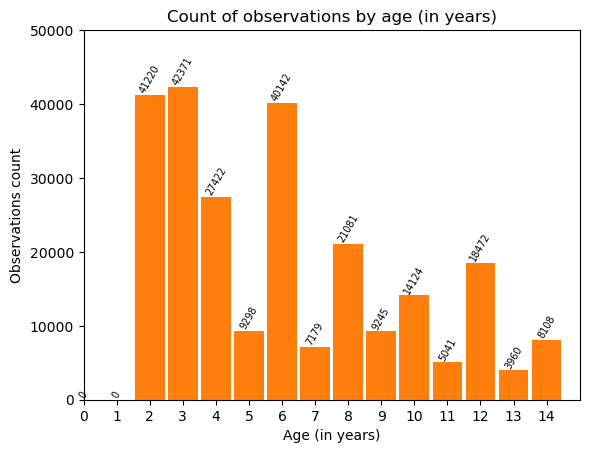

In [11]:
# Plot observations by age_years
n_patients = data.age_years.apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 50000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of observations by age (in years)")
ax.set_ylabel("Observations count")
ax.set_xlabel("Age (in years)")

plt.show()

We will consider the following models for comparison: LSTM, GRU, Random Forest, XGBoost, HMM, and Gaussian Processes.

To train the models reshaping of our data is needed so we have one row per patient.

In [12]:
# Modify data
data["age_years"] = data["age_years"].apply(math.trunc)
data = data.loc[:, ["subjid", "sex", "age_years", "zbmi", "zbmi_type"]]
data.head(10)

,subjid,sex,age_years,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,3,1.30,Overweight
2,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,4,0.73,Normal_weight
3,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,6,1.52,Overweight
4,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,8,1.70,Overweight
5,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,4,0.79,Normal_weight
6,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,6,0.66,Normal_weight
7,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,8,0.23,Normal_weight
8,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,10,0.59,Normal_weight
9,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,12,0.58,Normal_weight


Analysis of the zbmi trayectories by age:

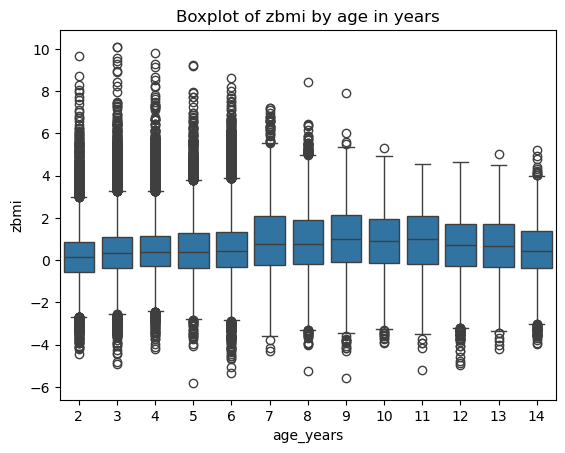

In [13]:
# Plot zbmi by age_years
sns.boxplot(x='age_years', y='zbmi', data=data)
plt.title("Boxplot of zbmi by age in years")
plt.show()

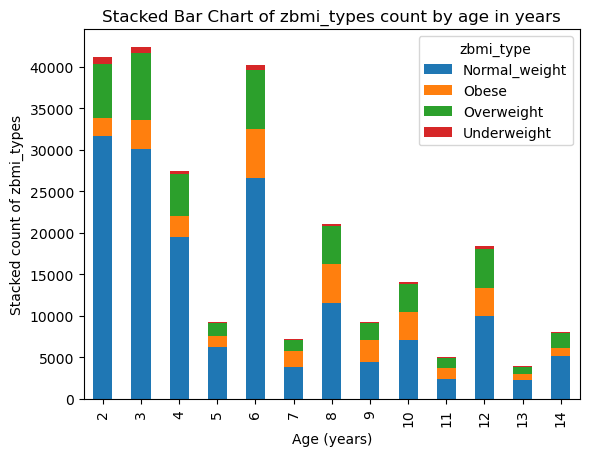

In [14]:
# Bar chart of each zbmi_type by age
stacked_counts = data.groupby(['age_years', 'zbmi_type']).size().unstack(fill_value=0)
stacked_counts.plot(kind='bar', stacked=True)

plt.xlabel('Age (years)')
plt.ylabel('Stacked count of zbmi_types')
plt.title('Stacked Bar Chart of zbmi_types count by age in years')

# Show the plot
plt.show()

Data reshaping

In [15]:
# Reshape data
zbmi_pivoted = data.pivot_table(index=["subjid", "sex"], columns="age_years", values="zbmi", aggfunc="mean")
zbmi_types_pivoted = data.pivot_table(index=["subjid", "sex"], columns="age_years", values="zbmi_type", aggfunc="first")

# Combine multilevel columns
zbmi_pivoted.columns = [f"zbmi_{col}" for col in zbmi_pivoted.columns]
zbmi_types_pivoted.columns = [f"zbmi_type_{col}" for col in zbmi_types_pivoted.columns]

# Combine data
pivot_data = pd.merge(zbmi_pivoted, zbmi_types_pivoted, on=["subjid", "sex"], how="inner")
pivot_data.reset_index(inplace=True)

pivot_data.head(5)

,subjid,sex,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,...,zbmi_type_5,zbmi_type_6,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1.24,1.30,0.73,NaN,1.52,NaN,1.70,NaN,...,NaN,Overweight,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,NaN,NaN,0.79,NaN,0.66,NaN,0.23,NaN,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,NaN,NaN,1.43,NaN,1.77,NaN,2.92,3.13,...,NaN,Overweight,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight
3,++FtKeESpTd0npbWZhKbKwz5udKbtTTDS02C,Female,0.77,1.06,NaN,1.3,NaN,NaN,NaN,NaN,...,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,++H+79RWVcymBKRpLj7G0Qz5udOavTvIR0uC,Male,NaN,0.63,NaN,NaN,0.83,NaN,NaN,NaN,...,NaN,Normal_weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Add ages again
names = ["age_" + str(x) for x in range(2, 15, 1)]
ages = [x for x in range(2, 15, 1)]
age_dict = dict(zip(names, ages))

for agename, agevalue in age_dict.items():
    pivot_data[agename] = agevalue

# Reorder columns
age_cols = [col for col in pivot_data.columns if 'age' in col]

pivot_data = pivot_data[["subjid", "sex"] + 
                        age_cols + 
                        [col for col in pivot_data.columns if col not in age_cols and col not in ["subjid", "sex"]]]


pivot_data.head(3)

,subjid,sex,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,...,zbmi_type_5,zbmi_type_6,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,2,3,4,5,6,7,8,9,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight


Since zbmi_types may have been altered, the variables will be relabeled.

In [17]:
# Correct labels of zbmi_types
for i in range(2, 15, 1):
    typezbmi = f"zbmi_type_{i}"
    zbmi = f"zbmi_{i}"
    for index, row in pivot_data.iterrows():
        if i < 5:
            match row[zbmi]:
                case value if value < -2.0:
                    pivot_data.at[index, typezbmi] = "Underweight"
                case value if value >= -2.0 and value <= 2.0:
                    pivot_data.at[index, typezbmi] = "Normal_weight"
                case value if value > 2.0 and value <= 3.0:
                    pivot_data.at[index, typezbmi] = "Overweight"
                case value if value > 3.0:
                    pivot_data.at[index, typezbmi] = "Obese"
                case _:
                    pivot_data.at[index, typezbmi] = np.nan
        if i >= 5:
            match row[zbmi]:
                case value if value < -2.0:
                    pivot_data.at[index, typezbmi] = "Underweight"
                case value if value >= -2.0 and value <= 1.0:
                    pivot_data.at[index, typezbmi] = "Normal_weight"
                case value if value > 1.0 and value <= 2.0:
                    pivot_data.at[index, typezbmi] = "Overweight"
                case value if value > 2.0:
                    pivot_data.at[index, typezbmi] = "Obese"
                case _:
                    pivot_data.at[index, typezbmi] = np.nan

One hot encode: the sex variable will be one-hot-encoded using sklearn.

In [18]:
# Encode sex variable
from sklearn.preprocessing import OneHotEncoder
sex_encoder = OneHotEncoder(sparse_output=False)
sex_encoded = sex_encoder.fit_transform(pivot_data["sex"].values.reshape(-1, 1))
sex_encoded_df = pd.DataFrame(sex_encoded, columns= sex_encoder.get_feature_names_out(['sex']))
pivot_data = pd.concat([pivot_data, sex_encoded_df], axis=1)

In [19]:
pivot_data.head(3)

,subjid,sex,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,...,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14,sex_Female,sex_Male
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,2,3,4,5,6,7,8,9,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN,0.0,1.0
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,2,3,4,5,6,7,8,9,...,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight,0.0,1.0


In [20]:
# Check if the patient number is not affected (check if data is lost)
len(pivot_data)

62798

Train test split

Data will be split between 67% train and 33% test, stratifying by sex and zbmi_type_14 label to ensure we
have some final data points in both train and test subsets. Some models need further preparation
after train-test split, so data will be prepared individually in order to maximize performance of
each model.

To test if the interpolated data and the real final data differ in results, we will also create a reduced version of the data with only real values at the age of 14, hence two models of each algorithm will be created (full and reduced). 

In [21]:
# Create a temporary column with combination of columns to stratify
pivot_data["stratify"] = pivot_data["sex"].astype(str) + "_" + pivot_data["zbmi_type_14"]
sex_column = pivot_data.pop("sex")

# Change stratify NaN to Unknown
pivot_data["stratify"] = pivot_data["stratify"].fillna("Unknown")

pivot_data.head(10)

,subjid,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,...,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14,sex_Female,sex_Male,stratify
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,2,3,4,5,6,7,8,9,10,...,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,2,3,4,5,6,7,8,9,10,...,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN,0.0,1.0,Unknown
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,2,3,4,5,6,7,8,9,10,...,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
3,++FtKeESpTd0npbWZhKbKwz5udKbtTTDS02C,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
4,++H+79RWVcymBKRpLj7G0Qz5udOavTvIR0uC,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,Unknown
5,++I9nc5fKbO/u4b1/2yTiQz5udKYvDzNTkGC,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
6,++L0bHwVuddtTPbPle9/ggz5uNubsDnCSkyG,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,Overweight,NaN,NaN,1.0,0.0,Unknown
7,++NsVGPHnkdWDpwjB16tQAz5udORsT7CR0GB,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,Obese,NaN,NaN,1.0,0.0,Unknown
8,++PF9XmuTG6SFeJwR1ZiBAz5udKctT7OSk6A,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown
9,++RKhV3ihA/cUyWtQJ+BFQz5udKQsT3CS0GB,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Unknown


The y variable must not contain any NaN values, hence the last available data is taken and added as an interpolated value.

In [ ]:
# Fill zbmi_14 with the last available data
zbmi_cols = [f'zbmi_{i}' for i in range(13, 1, -1)]
zbmi_cols.insert(0, 'zbmi_14')
pivot_data['zbmi_14'] = pivot_data['zbmi_14'].fillna(pivot_data[zbmi_cols].bfill(axis=1).iloc[:, 0])
pivot_data[zbmi_cols].head(10)

,zbmi_14,zbmi_13,zbmi_12,zbmi_11,zbmi_10,zbmi_9,zbmi_8,zbmi_7,zbmi_6,zbmi_5,zbmi_4,zbmi_3,zbmi_2
0,1.70,NaN,NaN,NaN,NaN,NaN,1.70,NaN,1.52,NaN,0.73,1.30,1.24
1,0.58,NaN,0.58,NaN,0.59,NaN,0.23,NaN,0.66,NaN,0.79,NaN,NaN
2,0.87,NaN,2.23,NaN,3.00,3.13,2.92,NaN,1.77,NaN,1.43,NaN,NaN
3,1.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30,NaN,1.06,0.77
4,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.83,NaN,NaN,0.63,NaN
5,1.92,NaN,NaN,NaN,NaN,NaN,NaN,1.92,NaN,NaN,NaN,1.55,NaN
6,1.37,NaN,1.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15
7,2.13,NaN,2.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,0.37,NaN
9,1.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.15,NaN,0.91,0.46


In [23]:
# Create reduced dataset
pivot_data_reduced = pivot_data[pivot_data["stratify"] != "Unknown"].copy()
pivot_data_reduced.head(10)

,subjid,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,...,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14,sex_Female,sex_Male,stratify
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,2,3,4,5,6,7,8,9,10,...,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
10,++TMQDydqMEDVhkvMZorEAz5uNqfvTjPSUCE,2,3,4,5,6,7,8,9,10,...,NaN,NaN,Obese,NaN,Obese,NaN,Overweight,0.0,1.0,Male_Overweight
12,++UQyyx5zN8/2ROXp2NM8Qz5uNqfsjvKSUyE,2,3,4,5,6,7,8,9,10,...,Normal_weight,NaN,NaN,NaN,Normal_weight,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
15,++mGjCfP1+SKGhi6zda2xAz5uNqftjrKRkGD,2,3,4,5,6,7,8,9,10,...,Normal_weight,NaN,NaN,NaN,Overweight,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
16,++ti/Fbi47RVATZ6735MfQz5uNqdsD7KR02E,2,3,4,5,6,7,8,9,10,...,Overweight,NaN,Overweight,NaN,Normal_weight,NaN,Normal_weight,1.0,0.0,Female_Normal_weight
28,+/CJg9A4oAdUU6bEm6imfAz5uNqetj7JSU6H,2,3,4,5,6,7,8,9,10,...,Obese,NaN,NaN,NaN,Obese,NaN,Obese,0.0,1.0,Male_Obese
36,+/heju9v6y4V9nLPYaWVOQz5uNqesTXIR0+C,2,3,4,5,6,7,8,9,10,...,NaN,NaN,Overweight,NaN,Overweight,NaN,Normal_weight,0.0,1.0,Male_Normal_weight
39,+/jbg4CGf7n7V0FNAfYWOAz5uNqftTjNTkyA,2,3,4,5,6,7,8,9,10,...,Normal_weight,NaN,NaN,NaN,Normal_weight,NaN,Normal_weight,1.0,0.0,Female_Normal_weight
51,+06aeVqt18DrW5Nbu+138Qz5uNqetj7MT06G,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,Obese,1.0,0.0,Female_Obese
55,+0EBI+ro95zfkfUlUsgn7wz5uNuZsTXPS0yE,2,3,4,5,6,7,8,9,10,...,Normal_weight,Normal_weight,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,0.0,1.0,Male_Normal_weight


In [24]:
pivot_data_reduced.shape

(7720, 43)

In [25]:
# Train-test split 67%-33%
y = pivot_data.pop("zbmi_14")

zbmis = pivot_data[[col for col in pivot_data.columns if '_type' not in col]]
pivot_data = pivot_data[[col for col in pivot_data.columns if '_type' not in col]]

xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(pivot_data.drop(columns=["age_14"]),
                                                                   y,
                                                                   test_size=0.33,
                                                                   random_state=42,
                                                                   stratify=pivot_data["stratify"])
stratify_column = pivot_data.pop("stratify")

In [26]:
# Train-test split 67%-33% pivot_data_reduced
reduced_y = pivot_data_reduced.pop("zbmi_14")

reduced_zbmis = pivot_data_reduced[[col for col in pivot_data_reduced.columns if '_type' not in col]]
pivot_data_reduced = pivot_data_reduced[[col for col in pivot_data_reduced.columns if '_type' not in col]]

reduced_xtrain, reduced_xtest, reduced_ytrain, reduced_ytest = sk.model_selection.train_test_split(pivot_data_reduced.drop(columns=["age_14"]),
                                                                   reduced_y,
                                                                   test_size=0.33,
                                                                   random_state=42,
                                                                   stratify=pivot_data_reduced["stratify"])
reduced_stratify_column = pivot_data_reduced.pop("stratify")

In [27]:
# Dataframe shapes
print(f"Xtrain: number of rows = {xtrain.shape[0]}, number of columns = {xtrain.shape[1]}")
print(f"Xtest: number of rows = {xtest.shape[0]}, number of columns = {xtest.shape[1]}")
print(f"Ytrain: number of rows = {ytrain.shape[0]}")
print(f"Ytest: number of rows = {ytest.shape[0]}")

# Reduced dataframe shapes
print(f"Reduced Xtrain: number of rows = {reduced_xtrain.shape[0]}, number of columns = {reduced_xtrain.shape[1]}")
print(f"Reduced Xtest: number of rows = {reduced_xtest.shape[0]}, number of columns = {reduced_xtest.shape[1]}")
print(f"Reduced Ytrain: number of rows = {reduced_ytrain.shape[0]}")
print(f"Reduced Ytest: number of rows = {reduced_ytest.shape[0]}")

Xtrain: number of rows = 42074, number of columns = 28
Xtest: number of rows = 20724, number of columns = 28
Ytrain: number of rows = 42074
Ytest: number of rows = 20724
Reduced Xtrain: number of rows = 5172, number of columns = 28
Reduced Xtest: number of rows = 2548, number of columns = 28
Reduced Ytrain: number of rows = 5172
Reduced Ytest: number of rows = 2548


Models:

The Long Short Term Memory (LSTM) and GRU models need a 3D array as input with the form of samples, time_steps, features, hence we will define a function to preprocess to 3D array. In our case, the samples are the rows, the time_steps are our 12 measurements (zbmi from ages 2 through 13) and features are the value at each time_step, and both sex columns since they are one-hot-encoded. We will also add a feature based on the stratify column, with 1 being we have a real target (y variable is not interpolated) and 0 if it is.

In [29]:
def preprocess_to_3d_array(df, measure_cols, sex_cols, real_col):
    measures = df[measure_cols].values.reshape(-1, len(measure_cols), 1)
    sex = df[sex_cols].values
    sex_repeated = np.repeat(sex[:, np.newaxis, :], len(measure_cols), axis=1)
    is_real_value = df[real_col].apply(lambda x: 0 if x == "Unknown" else 1).values
    is_real_value = is_real_value.reshape(-1, 1, 1)
    is_real_value = np.repeat(is_real_value, len(measure_cols), axis=1)
    Combined_array = np.concatenate([measures, sex_repeated, is_real_value], axis=2)
    return Combined_array

In [30]:
# Create 3d arrays for LSTM and GRU models
Measure_cols_3d_array = [f"zbmi_{i}" for i in range(2, 14)]
full_xtrain_3d = preprocess_to_3d_array(xtrain, Measure_cols_3d_array, ["sex_Female", "sex_Male"], "stratify")
full_xtest_3d = preprocess_to_3d_array(xtest, Measure_cols_3d_array, ["sex_Female", "sex_Male"], "stratify")
reduced_xtrain_3d = preprocess_to_3d_array(reduced_xtrain, Measure_cols_3d_array, ["sex_Female", "sex_Male"], "stratify")
reduced_xtest_3d = preprocess_to_3d_array(reduced_xtest, Measure_cols_3d_array, ["sex_Female", "sex_Male"], "stratify")

# Convert NaN to a number for masking
full_xtrain_3d = np.nan_to_num(full_xtrain_3d, nan=999.0)
full_xtest_3d = np.nan_to_num(full_xtest_3d, nan=999.0)
reduced_xtrain_3d = np.nan_to_num(reduced_xtrain_3d, nan=999.0)
reduced_xtest_3d = np.nan_to_num(reduced_xtest_3d, nan=999.0)

In [31]:
print(f"full_xtrain_3d shape: {full_xtrain_3d.shape}, full_xtest_3d shape: {full_xtest_3d.shape}")
print(f"reduced_xtrain_3d shape: {reduced_xtrain_3d.shape}, reduced_xtest_3d shape: {reduced_xtest_3d.shape}")

full_xtrain_3d shape: (42074, 12, 4), full_xtest_3d shape: (20724, 12, 4)
reduced_xtrain_3d shape: (5172, 12, 4), reduced_xtest_3d shape: (2548, 12, 4)


LSTM

We will create two LSTM models: one where the weight is calculated with a specific function (manual_lstm) and the second one using the Sequential approach (seq_lstm).

Manual LSTM

In [32]:
# Manual LSTM Model
class manual_LSTM_model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.masking = tf.keras.layers.Masking(mask_value=999.0)
        self.lstm = tf.keras.layers.LSTM(64, return_sequences = True)
        self.lstm2 = tf.keras.layers.LSTM(32, return_sequences = False)
        self.dense32 = tf.keras.layers.Dense(32, activation = "relu")
        self.dense1 = tf.keras.layers.Dense(1, activation = "linear")
        self.mae = tf.keras.metrics.MeanAbsoluteError()
    
    def call(self, inputs, training=False):
        x = self.lstm(inputs)
        x = self.lstm2(x)
        x = self.dense32(x)
        return self.dense1(x)
    
    def compute_weights(self, inputs):
        values = inputs[:, :, 0]
        is_not_nan = ~tf.math.is_nan(values)
        reversed_mask = tf.reverse(is_not_nan, axis=[1])
        last_real_index = tf.argmax(tf.cast(reversed_mask, tf.float32), axis=1)
        last_real_index = 12 - 1 - tf.cast(last_real_index, tf.float32)
        max_distance = tf.constant(12.0)
        recency_weight = 1.0 - (last_real_index / max_distance)
        y_is_real = inputs[:, -1, -1]
        y_is_real = tf.cast(y_is_real, tf.float32)
        return recency_weight * y_is_real

    def compute_real_mae(self, y_true, y_pred, is_real):
        is_real = tf.cast(is_real, tf.float32)
        abs_error = tf.abs(y_true - y_pred)
        masked_error = abs_error * is_real[:, tf.newaxis]

        total_error = tf.reduce_sum(masked_error)
        count = tf.reduce_sum(is_real)
        return total_error / (count + 1e-6)

    def train_step(self, data):
        inputs, y_true = data
        y_is_real = inputs[:, -1, -1]

        with tf.GradientTape() as tape:
            y_pred = self(inputs, training = True)
            weights = self.compute_weights(inputs)
            loss = tf.reduce_mean(tf.abs(y_true - y_pred) * weights[:, tf.newaxis])
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.mae.update_state(y_true, y_pred)
        real_mae = self.compute_real_mae(y_true, y_pred, y_is_real)
        
        return {"loss": loss, "mae": self.mae.result(), "real_mae": real_mae}

In [33]:
# Instantiate, compile and fit model
manual_lstm_full_model = manual_LSTM_model()
manual_lstm_full_model.compile(optimizer = "adam")
manual_lstm_full_model_history = manual_lstm_full_model.fit(full_xtrain_3d, ytrain, epochs = 10, batch_size = 32)

Epoch 1/10
1315/1315 [==============================] - 20s 10ms/step - loss: 0.0057 - mae: 0.6588 - real_mae: 0.5517
Epoch 2/10
1315/1315 [==============================] - 12s 9ms/step - loss: 0.0050 - mae: 0.4143 - real_mae: 0.4794
Epoch 3/10
1315/1315 [==============================] - 13s 10ms/step - loss: 0.0049 - mae: 0.4171 - real_mae: 0.4774
Epoch 4/10
1315/1315 [==============================] - 12s 9ms/step - loss: 0.0049 - mae: 0.4021 - real_mae: 0.4684
Epoch 5/10
1315/1315 [==============================] - 12s 9ms/step - loss: 0.0048 - mae: 0.3726 - real_mae: 0.4631
Epoch 6/10
1315/1315 [==============================] - 13s 10ms/step - loss: 0.0049 - mae: 0.3925 - real_mae: 0.4723
Epoch 7/10
1315/1315 [==============================] - 12s 9ms/step - loss: 0.0048 - mae: 0.4076 - real_mae: 0.4636
Epoch 8/10
1315/1315 [==============================] - 13s 10ms/step - loss: 0.0048 - mae: 0.3697 - real_mae: 0.4564
Epoch 9/10
1315/1315 [==============================] - 13s 

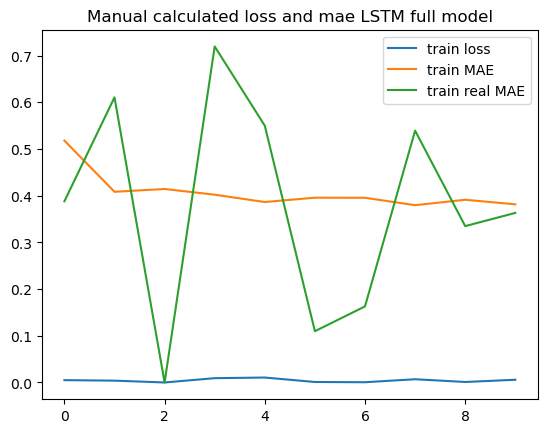

In [34]:
# Plot history
plt.plot(manual_lstm_full_model_history.history['loss'], label='train loss')
plt.plot(manual_lstm_full_model_history.history['mae'], label='train MAE')
plt.plot(manual_lstm_full_model_history.history['real_mae'], label='train real MAE')
plt.legend()
plt.title("Manual calculated loss and mae LSTM full model")
plt.show()

Sequential LSTM

In [35]:
# Full sequential lstm model
seq_lstm_full_model = tf.keras.models.Sequential()
seq_lstm_full_model.add(tf.keras.layers.Input(shape=(12, 4)))
seq_lstm_full_model.add(tf.keras.layers.Masking(mask_value=999.0))
seq_lstm_full_model.add(tf.keras.layers.LSTM(64))
seq_lstm_full_model.add(tf.keras.layers.Dense(1, activation='linear'))
seq_lstm_full_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [36]:
# Reduced sequential lstm model
seq_lstm_reduced_model = tf.keras.models.Sequential()
seq_lstm_reduced_model.add(tf.keras.layers.Input(shape=(12, 4)))
seq_lstm_reduced_model.add(tf.keras.layers.Masking(mask_value=999.0))
seq_lstm_reduced_model.add(tf.keras.layers.LSTM(64))
seq_lstm_reduced_model.add(tf.keras.layers.Dense(1, activation='linear'))
seq_lstm_reduced_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [37]:
seq_lstm_full_model_history = seq_lstm_full_model.fit(full_xtrain_3d, ytrain, epochs=10, batch_size=32, validation_split = 0.2)

Epoch 1/10
1052/1052 [==============================] - 16s 9ms/step - loss: 0.3462 - mae: 0.3389 - val_loss: 0.0682 - val_mae: 0.1390
Epoch 2/10
1052/1052 [==============================] - 8s 7ms/step - loss: 0.0616 - mae: 0.1207 - val_loss: 0.0541 - val_mae: 0.1043
Epoch 3/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0530 - mae: 0.1045 - val_loss: 0.0548 - val_mae: 0.1301
Epoch 4/10
1052/1052 [==============================] - 8s 7ms/step - loss: 0.0500 - mae: 0.0970 - val_loss: 0.0485 - val_mae: 0.0925
Epoch 5/10
1052/1052 [==============================] - 8s 7ms/step - loss: 0.0498 - mae: 0.0971 - val_loss: 0.0476 - val_mae: 0.0835
Epoch 6/10
1052/1052 [==============================] - 8s 7ms/step - loss: 0.0489 - mae: 0.0952 - val_loss: 0.0472 - val_mae: 0.0904
Epoch 7/10
1052/1052 [==============================] - 8s 7ms/step - loss: 0.0481 - mae: 0.0938 - val_loss: 0.0461 - val_mae: 0.0789
Epoch 8/10
1052/1052 [==============================] - 8s 7m

In [38]:
seq_lstm_reduced_model_history = seq_lstm_reduced_model.fit(reduced_xtrain_3d, reduced_ytrain, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20
130/130 [==============================] - 9s 22ms/step - loss: 0.9018 - mae: 0.7416 - val_loss: 0.6135 - val_mae: 0.6107
Epoch 2/20
130/130 [==============================] - 1s 8ms/step - loss: 0.5011 - mae: 0.5457 - val_loss: 0.4418 - val_mae: 0.5150
Epoch 3/20
130/130 [==============================] - 1s 9ms/step - loss: 0.4150 - mae: 0.4956 - val_loss: 0.3895 - val_mae: 0.4765
Epoch 4/20
130/130 [==============================] - 1s 7ms/step - loss: 0.3840 - mae: 0.4735 - val_loss: 0.3620 - val_mae: 0.4580
Epoch 5/20
130/130 [==============================] - 1s 7ms/step - loss: 0.3776 - mae: 0.4707 - val_loss: 0.3613 - val_mae: 0.4550
Epoch 6/20
130/130 [==============================] - 1s 7ms/step - loss: 0.3764 - mae: 0.4704 - val_loss: 0.3540 - val_mae: 0.4522
Epoch 7/20
130/130 [==============================] - 1s 8ms/step - loss: 0.3678 - mae: 0.4652 - val_loss: 0.3559 - val_mae: 0.4554
Epoch 8/20
130/130 [==============================] - 1s 9ms/step - loss: 0

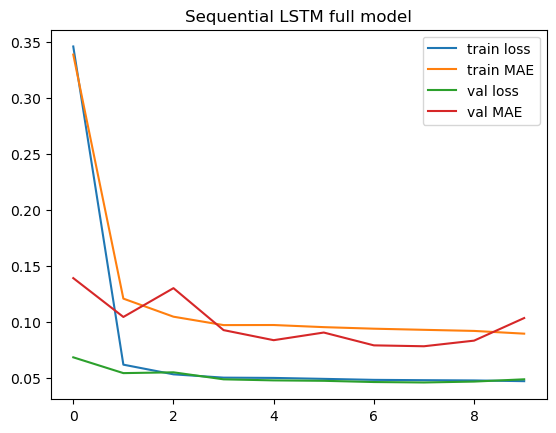

In [39]:
# Plot history
plt.plot(seq_lstm_full_model_history.history['loss'], label='train loss')
plt.plot(seq_lstm_full_model_history.history['mae'], label='train MAE')
plt.plot(seq_lstm_full_model_history.history['val_loss'], label='val loss')
plt.plot(seq_lstm_full_model_history.history['val_mae'], label='val MAE')
plt.legend()
plt.title("Sequential LSTM full model")
plt.show()

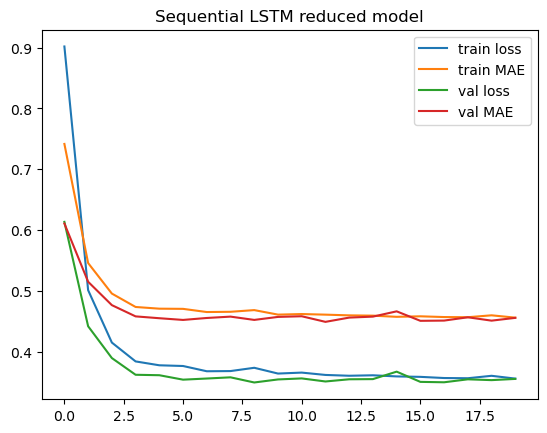

In [40]:
# Plot history
plt.plot(seq_lstm_reduced_model_history.history['loss'], label='train loss')
plt.plot(seq_lstm_reduced_model_history.history['mae'], label='train MAE')
plt.plot(seq_lstm_reduced_model_history.history['val_loss'], label='val loss')
plt.plot(seq_lstm_reduced_model_history.history['val_mae'], label='val MAE')
plt.legend()
plt.title("Sequential LSTM reduced model")
plt.show()

GRU

In [41]:
# Full GRU model
gru_full_model = tf.keras.models.Sequential()
gru_full_model.add(tf.keras.layers.Input(shape=(12, 4)))
gru_full_model.add(tf.keras.layers.Masking(mask_value=999.0))
gru_full_model.add(tf.keras.layers.GRU(64))
gru_full_model.add(tf.keras.layers.Dense(1, activation='linear'))
gru_full_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [42]:
# Reduced GRU model
gru_reduced_model = tf.keras.models.Sequential()
gru_reduced_model.add(tf.keras.layers.Input(shape=(12, 4)))
gru_reduced_model.add(tf.keras.layers.Masking(mask_value=999.0))
gru_reduced_model.add(tf.keras.layers.GRU(64))
gru_reduced_model.add(tf.keras.layers.Dense(1, activation='linear'))
gru_reduced_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [43]:
gru_full_model_history = gru_full_model.fit(full_xtrain_3d, ytrain, epochs=10, batch_size=32, validation_split = 0.2)

Epoch 1/10
1052/1052 [==============================] - 16s 9ms/step - loss: 0.1246 - mae: 0.1777 - val_loss: 0.0496 - val_mae: 0.0902
Epoch 2/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0505 - mae: 0.0972 - val_loss: 0.0471 - val_mae: 0.0910
Epoch 3/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0489 - mae: 0.0958 - val_loss: 0.0460 - val_mae: 0.0784
Epoch 4/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0474 - mae: 0.0902 - val_loss: 0.0460 - val_mae: 0.0865
Epoch 5/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0469 - mae: 0.0874 - val_loss: 0.0468 - val_mae: 0.0893
Epoch 6/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0462 - mae: 0.0846 - val_loss: 0.0457 - val_mae: 0.0845
Epoch 7/10
1052/1052 [==============================] - 8s 8ms/step - loss: 0.0461 - mae: 0.0834 - val_loss: 0.0506 - val_mae: 0.1174
Epoch 8/10
1052/1052 [==============================] - 8s 8m

In [44]:
gru_reduced_model_history = gru_reduced_model.fit(reduced_xtrain_3d, reduced_ytrain, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20
130/130 [==============================] - 9s 22ms/step - loss: 0.5474 - mae: 0.5687 - val_loss: 0.3807 - val_mae: 0.4694
Epoch 2/20
130/130 [==============================] - 1s 8ms/step - loss: 0.3849 - mae: 0.4750 - val_loss: 0.3900 - val_mae: 0.4869
Epoch 3/20
130/130 [==============================] - 1s 9ms/step - loss: 0.3780 - mae: 0.4719 - val_loss: 0.3566 - val_mae: 0.4553
Epoch 4/20
130/130 [==============================] - 1s 10ms/step - loss: 0.3702 - mae: 0.4664 - val_loss: 0.3590 - val_mae: 0.4574
Epoch 5/20
130/130 [==============================] - 1s 8ms/step - loss: 0.3715 - mae: 0.4670 - val_loss: 0.3578 - val_mae: 0.4577
Epoch 6/20
130/130 [==============================] - 1s 8ms/step - loss: 0.3683 - mae: 0.4660 - val_loss: 0.3491 - val_mae: 0.4486
Epoch 7/20
130/130 [==============================] - 1s 10ms/step - loss: 0.3691 - mae: 0.4638 - val_loss: 0.3552 - val_mae: 0.4552
Epoch 8/20
130/130 [==============================] - 1s 9ms/step - loss:

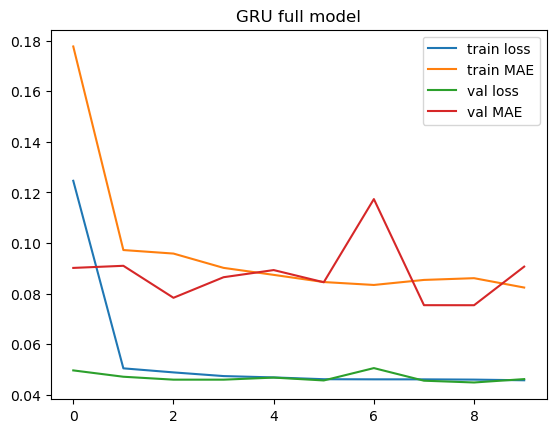

In [45]:
# Plot history
plt.plot(gru_full_model_history.history['loss'], label='train loss')
plt.plot(gru_full_model_history.history['mae'], label='train MAE')
plt.plot(gru_full_model_history.history['val_loss'], label='val loss')
plt.plot(gru_full_model_history.history['val_mae'], label='val MAE')
plt.legend()
plt.title("GRU full model")
plt.show()

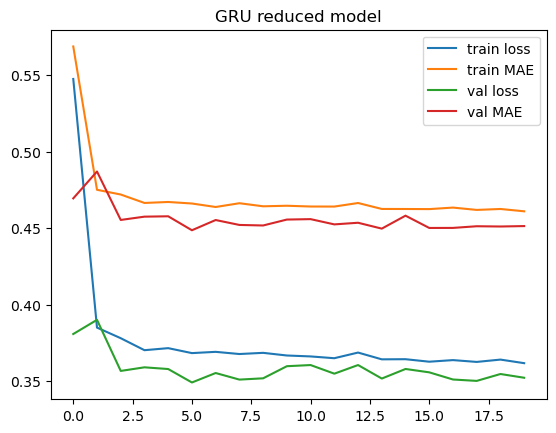

In [46]:
# Plot history
plt.plot(gru_reduced_model_history.history['loss'], label='train loss')
plt.plot(gru_reduced_model_history.history['mae'], label='train MAE')
plt.plot(gru_reduced_model_history.history['val_loss'], label='val loss')
plt.plot(gru_reduced_model_history.history['val_mae'], label='val MAE')
plt.legend()
plt.title("GRU reduced model")
plt.show()

For Random Forest and XGBoost, a dataframe can be passed directly, however, we will mask the NaN values in the RF models due to their inhability to work natively with them.

In [47]:
# Optimize dataset for tree models
cols_for_tree_models = [*["zbmi_" + str(i) for i in range(2, 14, 1)], "sex_Female", "sex_Male", "stratify"]

# Full models
tree_xtrain = xtrain[cols_for_tree_models].copy()
tree_xtest = xtest[cols_for_tree_models].copy()

tree_xtrain.loc[:, "stratify"] = tree_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
tree_xtest.loc[:, "stratify"] = tree_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

tree_xtrain["stratify"] = tree_xtrain["stratify"].astype(float)
tree_xtest["stratify"] = tree_xtest["stratify"].astype(float)

# Reduced models
tree_reduced_xtrain = reduced_xtrain[cols_for_tree_models].copy()
tree_reduced_xtest = reduced_xtest[cols_for_tree_models].copy()

tree_reduced_xtrain.loc[:, "stratify"] = tree_reduced_xtrain["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)
tree_reduced_xtest.loc[:, "stratify"] = tree_reduced_xtest["stratify"].apply(lambda x: 1 if x == "Unknown" else 0)

tree_reduced_xtrain["stratify"] = tree_reduced_xtrain["stratify"].astype(float)
tree_reduced_xtest["stratify"] = tree_reduced_xtest["stratify"].astype(float)

Random Forest

As mentioned previously, we will further preprocess the RF data for optimization.

In [48]:
def process_cols_RF(df):
    df = df.copy()
    for i in range(2, 14, 1):
        zbmi_col = "zbmi_" + str(i)
        missing_col = "missing_zbmi_" + str(i)
        df.loc[:, missing_col] = df[zbmi_col].apply(lambda x: 1 if pd.isna(x) else 0)
        df.loc[:, zbmi_col] = df[zbmi_col].fillna(999.0)

    return df

In [49]:
RF_xtrain = process_cols_RF(tree_xtrain)
RF_xtest = process_cols_RF(tree_xtest)
RF_reduced_xtrain = process_cols_RF(tree_reduced_xtrain)
RF_reduced_xtest = process_cols_RF(tree_reduced_xtest)

In [50]:
RF_xtrain.head(10)

,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,...,missing_zbmi_4,missing_zbmi_5,missing_zbmi_6,missing_zbmi_7,missing_zbmi_8,missing_zbmi_9,missing_zbmi_10,missing_zbmi_11,missing_zbmi_12,missing_zbmi_13
25106,0.87,1.67,999.00,999.00,999.00,999.0,999.00,999.0,999.00,999.00,...,1,1,1,1,1,1,1,1,1,1
36361,999.00,999.00,0.44,999.00,0.81,999.0,1.09,999.0,999.00,999.00,...,0,1,0,1,0,1,1,1,0,1
8380,999.00,999.00,999.00,999.00,999.00,999.0,999.00,999.0,999.00,1.25,...,1,1,1,1,1,1,1,0,0,1
6827,999.00,999.00,999.00,999.00,0.45,999.0,-0.29,999.0,-0.24,999.00,...,1,1,0,1,0,1,0,1,0,1
52767,999.00,999.00,1.05,1.79,999.00,999.0,999.00,999.0,999.00,999.00,...,0,0,1,1,1,1,1,1,1,1
47167,999.00,1.28,1.34,999.00,1.04,999.0,999.00,999.0,999.00,999.00,...,0,1,0,1,1,1,1,1,1,1
60880,1.68,0.83,999.00,999.00,999.00,999.0,999.00,999.0,999.00,999.00,...,1,1,1,1,1,1,1,1,1,1
43668,999.00,-0.97,999.00,999.00,1.11,999.0,1.40,999.0,1.58,999.00,...,1,1,0,1,0,1,0,1,0,1
17764,999.00,999.00,2.69,999.00,1.70,999.0,999.00,999.0,999.00,999.00,...,0,1,0,1,1,1,1,1,1,1
62483,999.00,1.09,999.00,999.00,0.42,999.0,999.00,999.0,999.00,999.00,...,1,1,0,1,1,1,1,1,1,1


In [51]:
# RF full model
RF_full_model = sk.ensemble.RandomForestRegressor(
    n_estimators = 100,
    max_depth = None,
    random_state = 42,
    n_jobs = -1)

RF_full_model.fit(RF_xtrain, ytrain)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [52]:
# RF reduced model
RF_reduced_model = sk.ensemble.RandomForestRegressor(
    n_estimators = 100,
    max_depth = None,
    random_state = 42,
    n_jobs = -1)

RF_reduced_model.fit(RF_reduced_xtrain, reduced_ytrain)

RandomForestRegressor(n_jobs=-1, random_state=42)

XGBoost

In [53]:
# XGB full model
XGB_full_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    missing=np.nan,
    random_state=42
)

XGB_full_model.fit(tree_xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [54]:
# XGB reduced model
XGB_reduced_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    missing=np.nan,
    random_state=42
)
XGB_reduced_model.fit(tree_reduced_xtrain, reduced_ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Hidden Markov Models (HMM)

HMM uses 2D arrays as inputs, so we will need to convert our data into a 2D array. Since HMMs do not work properly with NaN, we will fill the values, first by forward propagation and then by backwards propagation in this order to ensure data is properly handled (backwards propagation is to ensure filling if data does not start at age 2.)

In [55]:
def hmm_preprocess(df, measure_cols):
    df = df.copy()
    df = df.ffill(axis = 1)
    df = df.bfill(axis = 1)
    HMM_measures = df[measure_cols].values.reshape(-1, len(measure_cols))
    HMM_combined = np.array(HMM_measures)
    return HMM_combined

In [56]:
HMM_xtrain = hmm_preprocess(tree_xtrain, cols_for_tree_models)
HMM_xtest = hmm_preprocess(tree_xtest, cols_for_tree_models)
HMM_reduced_xtrain = hmm_preprocess(tree_reduced_xtrain, cols_for_tree_models)
HMM_reduced_xtest = hmm_preprocess(tree_reduced_xtest, cols_for_tree_models)

In [57]:
print(f"HMM xtrain shape: {HMM_xtrain.shape}, HMM test shape: {HMM_xtest.shape}")
print(f"HMM reduced xtrain shape: {HMM_reduced_xtrain.shape}, HMM reduced test shape: {HMM_reduced_xtest.shape}")

HMM xtrain shape: (42074, 15), HMM test shape: (20724, 15)
HMM reduced xtrain shape: (5172, 15), HMM reduced test shape: (2548, 15)


In [58]:
# HMM full model
HMM_full_model = GaussianHMM(n_components=4, covariance_type="full", n_iter=1000)
HMM_full_model.fit(HMM_xtrain)

c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\admin\anaconda3\envs\tfm_ml\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\admin\anaconda3\envs\tfm_ml\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\admin\anaconda3\envs\tfm_ml\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.Create

GaussianHMM(covariance_type='full', n_components=4, n_iter=1000)

In [59]:
# HMM reduced model
HMM_reduced_model = GaussianHMM(n_components=4, covariance_type="full", n_iter=1000)
HMM_reduced_model.fit(HMM_reduced_xtrain)

Model is not converging.  Current: 49625.274767923045 is not greater than 63785.74015994783. Delta is -14160.465392024787


GaussianHMM(covariance_type='full', n_components=4, n_iter=1000)

Gaussian Processes (GP)

These types of models do not handle well big datasets, however we will try to use them since we also have a subset of our data. The only necessary preprocessing is to mask NaN values by filling.

In [60]:
def gp_preprocess(df):
    df = df.copy()
    df = df.ffill(axis = 1)
    df = df.bfill(axis = 1)
    return df

In [61]:
GP_xtrain = gp_preprocess(tree_xtrain)
GP_xtest = gp_preprocess(tree_xtest)
GP_reduced_xtrain = gp_preprocess(tree_reduced_xtrain)
GP_reduced_xtest = gp_preprocess(tree_reduced_xtest)

In [62]:
# GP full model
GP_full_model = sk.gaussian_process.GaussianProcessRegressor()
# GP_full_model.fit(GP_xtrain, ytrain)

In [63]:
# GP reduced model
GP_reduced_model = sk.gaussian_process.GaussianProcessRegressor()
GP_reduced_model.fit(GP_reduced_xtrain, reduced_ytrain)

GaussianProcessRegressor()

After trying multiple options, we conclude it is computationally unfeasable to make a Gaussian Process model the full dataset due to being excessively large for the model to handle.

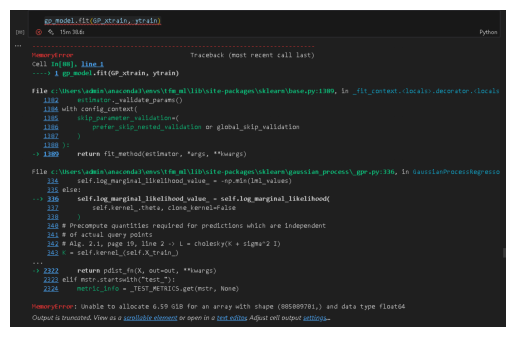

In [64]:
gp_model_error = mpimg.imread('gp_model_error.png')
plt.imshow(gp_model_error)
plt.axis('off')
plt.show()

Predictions and model evaluation

In [65]:
full_model_preds = {
    "manual_lstm_full_model_preds": manual_lstm_full_model.predict(full_xtest_3d),
    "seq_lstm_full_model_preds": seq_lstm_full_model.predict(full_xtest_3d),
    "gru_full_model_preds": gru_full_model.predict(full_xtest_3d),
    "RF_full_model_preds": RF_full_model.predict(RF_xtest),
    "XGB_full_model_preds": XGB_full_model.predict(tree_xtest),
    "HMM_full_model_preds": HMM_full_model.predict(HMM_xtest)
}

reduced_model_preds = {
    "seq_lstm_reduced_model_preds": seq_lstm_reduced_model.predict(reduced_xtest_3d),
    "gru_reduced_model_preds": gru_reduced_model.predict(reduced_xtest_3d),
    "RF_reduced_model_preds": RF_reduced_model.predict(RF_reduced_xtest),
    "XGB_reduced_model_preds": XGB_reduced_model.predict(tree_reduced_xtest),
    "HMM_reduced_model_preds": HMM_reduced_model.predict(HMM_reduced_xtest),
    "GP_reduced_model_preds" : GP_reduced_model.predict(GP_reduced_xtest)
}

80/80 [==============================] - 2s 3ms/step


In [66]:
manual_lstm_full_model_loss, manual_lstm_full_model_accuracy = manual_lstm_full_model.evaluate(full_xtest_3d, ytest)

648/648 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00


In [67]:
seq_lstm_full_model_loss, seq_lstm_full_model_accuracy = seq_lstm_full_model.evaluate(full_xtest_3d, ytest)

648/648 [==============================] - 2s 3ms/step - loss: 0.0483 - mae: 0.1027


In [68]:
seq_lstm_reduced_model_loss, seq_lstm_full_model_accuracy = seq_lstm_reduced_model.evaluate(reduced_xtest_3d, reduced_ytest)

80/80 [==============================] - 0s 5ms/step - loss: 0.3567 - mae: 0.4581


In [69]:
gru_full_model_loss, gru_full_model_accuracy = gru_full_model.evaluate(full_xtest_3d, ytest)

648/648 [==============================] - 2s 3ms/step - loss: 0.0455 - mae: 0.0895


In [70]:
gru_reduced_model_loss, gru_reduced_model_accuracy = gru_reduced_model.evaluate(reduced_xtest_3d, reduced_ytest)

80/80 [==============================] - 0s 5ms/step - loss: 0.3589 - mae: 0.4564


We will convert our ytest into labels and proceed to do the same with our predictions

In [71]:
# Define a converter function
def convert_to_label(predictions):
    labels = []
    for prediction in predictions:
        match prediction:
            case _ if prediction < -2.0:
                labels.append("Underweight")
            case _ if -2.0 <= prediction <= 1.0:
                labels.append("Normal_weight")
            case _ if 1.0 < prediction <= 2.0:
                labels.append("Overweight")
            case _ if prediction > 2.0:
                labels.append("Obese")
            case _:
                labels.append(np.nan)
    
    return labels

In [72]:
labels_ytest = convert_to_label(ytest)
labels_reduced_ytest = convert_to_label(reduced_ytest)
labels_ytest[0:5]

['Obese', 'Normal_weight', 'Normal_weight', 'Obese', 'Overweight']

In [73]:
# Convert to labels our predictions
full_model_labels = {}
for model_predictions, predictions in full_model_preds.items():
    model_labels = re.sub(r"preds$", "labels", model_predictions)
    full_model_labels[model_labels] = convert_to_label(predictions)

reduced_model_labels = {}
for model_predictions, predictions in reduced_model_preds.items():
    model_labels = re.sub(r"preds$", "labels", model_predictions)
    reduced_model_labels[model_labels] = convert_to_label(predictions)

We will print the classification reports of each model

In [74]:
for model, output in full_model_labels.items():
    print(f"Model: {model}")
    print(classification_report(labels_ytest, output), flush= True)

Model: manual_lstm_full_model_labels
               precision    recall  f1-score   support

Normal_weight       0.86      0.99      0.92     13185
        Obese       0.96      0.51      0.67      2905
   Overweight       0.61      0.56      0.59      4222
  Underweight       0.82      0.27      0.41       412

     accuracy                           0.82     20724
    macro avg       0.81      0.58      0.65     20724
 weighted avg       0.82      0.82      0.81     20724

Model: seq_lstm_full_model_labels
               precision    recall  f1-score   support

Normal_weight       0.98      0.97      0.98     13185
        Obese       0.92      0.96      0.94      2905
   Overweight       0.88      0.91      0.89      4222
  Underweight       0.96      0.86      0.91       412

     accuracy                           0.95     20724
    macro avg       0.94      0.92      0.93     20724
 weighted avg       0.95      0.95      0.95     20724

Model: gru_full_model_labels
              

c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
for model, output in reduced_model_labels.items():
    print(f"Model: {model}")
    print(classification_report(labels_reduced_ytest, output), flush= True)

Model: seq_lstm_reduced_model_labels
               precision    recall  f1-score   support

Normal_weight       0.87      0.92      0.89      1633
        Obese       0.79      0.57      0.66       307
   Overweight       0.57      0.60      0.59       553
  Underweight       0.73      0.35      0.47        55

     accuracy                           0.79      2548
    macro avg       0.74      0.61      0.65      2548
 weighted avg       0.79      0.79      0.79      2548

Model: gru_reduced_model_labels
               precision    recall  f1-score   support

Normal_weight       0.88      0.90      0.89      1633
        Obese       0.82      0.55      0.66       307
   Overweight       0.56      0.66      0.61       553
  Underweight       0.88      0.25      0.39        55

     accuracy                           0.79      2548
    macro avg       0.78      0.59      0.64      2548
 weighted avg       0.80      0.79      0.79      2548

Model: RF_reduced_model_labels
              

c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\tfm_ml\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We will also use the mean_absolute_error to compare the raw outputs of the models

In [81]:
for model, prediction in full_model_preds.items():
    mae = round(mean_absolute_error(ytest, prediction), 5)
    mse = round(mean_squared_error(ytest, prediction), 5)
    print(f"Model: {model}, MAE: {mae}, MSE: {mse}")

Model: manual_lstm_full_model_preds, MAE: 0.38235, MSE: 0.26199
Model: seq_lstm_full_model_preds, MAE: 0.10272, MSE: 0.04832
Model: gru_full_model_preds, MAE: 0.08953, MSE: 0.04551
Model: RF_full_model_preds, MAE: 0.1458, MSE: 0.11417
Model: XGB_full_model_preds, MAE: 0.22794, MSE: 0.1329
Model: HMM_full_model_preds, MAE: 2.1708, MSE: 6.34073


In [82]:
for model, prediction in reduced_model_preds.items():
    mae = round(mean_absolute_error(reduced_ytest, prediction), 5)
    mse = round(mean_squared_error(reduced_ytest, prediction), 5)
    print(f"Model: {model}, MAE: {mae}, MSE: {mse}")

Model: seq_lstm_reduced_model_preds, MAE: 0.45809, MSE: 0.3567
Model: gru_reduced_model_preds, MAE: 0.45641, MSE: 0.35889
Model: RF_reduced_model_preds, MAE: 0.49806, MSE: 0.41968
Model: XGB_reduced_model_preds, MAE: 0.47586, MSE: 0.38441
Model: HMM_reduced_model_preds, MAE: 1.81966, MSE: 4.6799
Model: GP_reduced_model_preds, MAE: 57.9359, MSE: 39472.7592


Model selection

After carefullly examining the models performance, the GRU full model is selected for the application.

In [85]:
gru_full_model.save('GRU_obesity_zbmi_predictor')

INFO:tensorflow:Assets written to: GRU_obesity_zbmi_predictor\assets


INFO:tensorflow:Assets written to: GRU_obesity_zbmi_predictor\assets
